<img align="right" width="30%"  src="https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif">

# Bayesian Inference Part 3: Bayesian Inference Software and Model Selection

### Erik Tollerud
[Space Telescope Science Institute](https://www.stsci.edu)


# Bayes' Theorem Review

As a reminder: Bayesian fundamentals were discussed in [Session 1](Session%201.ipynb). Particuarly, a few key pieces of terminology:

$\color{red}{P({\rm Hypothesis}|{\rm Data})} = \color{green}{P({\rm Data}|{\rm Hypothesis})} \frac{\color{blue}{P({\rm Hypothesis})}}{\color{magenta}{P({\rm Data})}}$

<font color='red'>Posterior Probability</font><br>
<font color='green'>Likelihood</font><br>
<font color='blue'>Prior Probability</font><br>
<font color='magenta'>Marginal Likelihood or "Model Evidence"</font>

(<font color='magenta' size="6">↑</font> This last one in particular will be very relevant this session!)

## The "model fitting" Form

$P(Model | Data) = P(Data | Model) \frac{P(Model)}{P(Data)}$

This at first appears to be all we need, but a "model" isn't a thing we fit on it's own. With numerical data, we usually have model *parameters*, which we collectively call $\Theta$ (Why that greek letter? Theta's a good question, I don't know...).  So we apply Bayes' Theorem to *that* under the assumption that the particular model in question is true:


$P(\Theta| D, M) = P(D| \Theta, M) \frac{P(\Theta|M)}{P(D | M)}$

In practice, the above is usually what we're usually most interested in when we do Bayesian Inference in astronomy, so we'll focus on that for now (but see the model selection discussion later for a part of the bigger picture).



# Model fitting Distributions

Also in practice, in astro we are usually thinking about continuous distributions, so these probabilities are also continuous distributions, making this a probability density function statement:

$\mathscr{P}(\Theta| D_i, M) = \frac{1}{Z} \mathscr{L}(X_i, \Theta) \pi(\Theta)$

where $Z$ (the evidence) can be treated as simply the  normalization constant to make P a probability distribution. Computing that Z can be tricky though, since it's an integral for a continuous probability distribution. That is, we need to do:

$Z = \int\mathscr{L}(X_i, \Theta) \pi(\Theta) d\Theta $

and then we can compute $\mathscr{P}(\Theta| D_i, M)$, which gives us our "model fits".

# So why do we need Inference software?

In principle we, don't. Back when astronomy "computers" were a [women working at Harvard](https://en.wikipedia.org/wiki/Harvard_Computers), analytic techniques were the only practical way to do Bayesian Inference. This tends to revolve around specific statistical distributions where if you choose magical forms for $ \mathscr{L}$ and $\pi$, you get a $\mathscr{P}$ with the same functional form as $\pi$.  Thus are called "conjugates" - i.e. a given likelihood function has a particular "conjugate prior". You can see a [nicely formatted table](https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions) of these on wikipedia.

The trouble with this is threefold: 
1. These really only work for fairly trivial likelihoods, like pure Gaussians, Binomials, single Poisson processes, etc. So any real physical model is generally right out.
2. You are *forced* by math to use a specific form of prior, so if your subjective prior belief doesn't follow that form, you're SOL.
3. Historically, [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) would shout at you if you did this, and say you should use frequentist techniques instead.

# Markov Chain Monte Carlo

Given the limitations of analytic methods, we need a way to somehow characterize $\mathscr{P}(\Theta| D_i, M)$ numerically. Bayesian Inference really came into its own with the recognition that methods developed from statistical mechanics can solve this problem. One key realization is that for parameter distributions you don't necessarily *need* to solve for $Z$. It's independent of all the $\Theta$s, so it's sufficient to say "if I get a bunch of samples from this distribution, I can just normalize by dividing by the number of samples".  It is exactly this problem that Markov Chain Monte Carlo (MCMC) codes are good at.

First we need to decode some of these words:

*  Markov Chain: Roughly speaking, this is a list of numbers generated by a process that doesn't care about its history: the "next" number only cares about the immediately previous one, not any of those further back.
*  Monte Carlo: using random numbers to do some sort of calculation.

As you can probably guess, the way astronomers sometimes use this: "I used MCMC", "I MCMCed it", or "I did it with that fancy MCMC thingie so it must be right" (all actual quotes...) is a very incomplete description. MCMC is a broad class of things, and we usually mean a much more limited subset. E.g. "I did Bayesian Inference using a Metropolis-Hastings-based MCMC code".  But that doesn't really roll off the tongue so... 🤷

## Metropolis-Hastings

In reality the important algorithm here is a specific type of MCMC method - the Metropolis-Hastings algorithm. At its core this means the following algorithm:

0. (Start from really anywhere in your $\Theta$ space)
1. Make a guess at a new value of the $\Theta$ parameters
2. Compute the likelihood times the prior for the new vs old value and take the ratio
3. Generate a random uniform value and accept if the random number is smaller than the ratio

That's it!  It's delicilously simple.  To illustrate, lets implement a trivial 1D M-H MCMC ourselves.

In [1]:
import numpy as np
rng = np.random.default_rng(44)

def next_sample(prev, likelihood_func, prior_distr, proposal_sig=1):
    next_maybe = prev + rng.normal()*proposal_sig
    next_p = likelihood_func(next_maybe)*prior_distr.pdf(next_maybe)
    prev_p = likelihood_func(prev)*prior_distr.pdf(prev)
    if rng.uniform() < next_p/prev_p:
        return next_maybe
    else:
        return prev

In [2]:
from scipy import stats

prior = stats.uniform(loc=0, scale=20) #[0, 20]
mu = 0

def gaussian_likelihood(sig, data):
    # we leave off the two pi because only proportionality matters
    likelihoods = np.exp(-0.5*((data-mu)/sig)**2)/sig
    return np.prod(likelihoods)

In [3]:
from matplotlib import pyplot as plt

def plot_data_samples(data, samples):
    fig = plt.figure(constrained_layout=True, figsize=(12, 4))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax1.plot(samples)
    ax1.axhline(true_sig, c='k', ls=':')
    ax2.hist(samples, bins='auto')
    ax2.axvline(true_sig, c='k', ls=':')
    ax2.axvline(np.median(samples), c='C0', ls='--')
    ax3.hist(data, bins=100, color='C1')
    ax3.plot([-true_sig/2, true_sig/2], 
             [0.35]*2, 
             c='k', ls=':')
    ax3.plot([-np.median(samples)/2, np.median(samples)/2], 
             [0.65]*2, 
             c='C0', ls='--')

In [4]:
from functools import partial

true_sig = 5.4
mock_data = rng.normal(0, true_sig, 10)
lf = partial(gaussian_likelihood, data=mock_data)

samples = [prior.rvs(random_state=rng)]
for _ in range(1000):
    samples.append(next_sample(samples[-1], lf, prior))

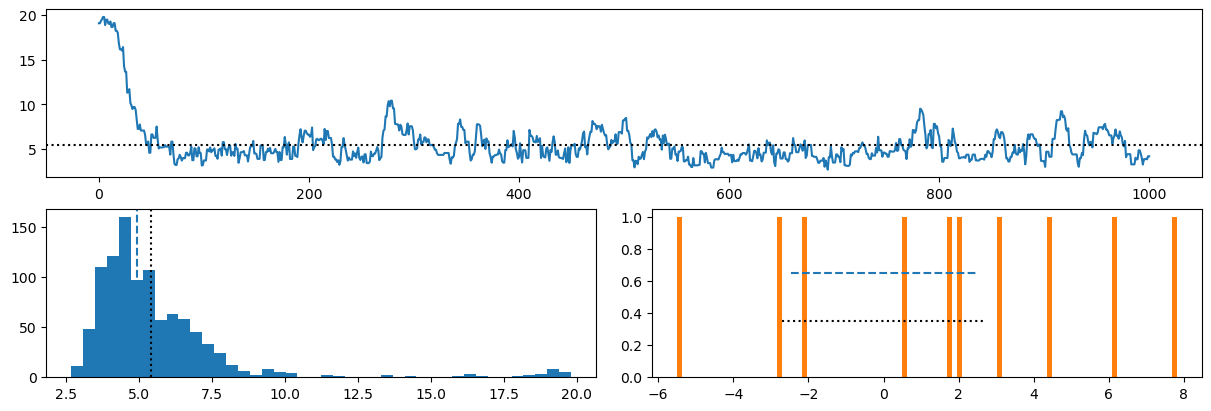

In [5]:
plot_data_samples(mock_data, samples)

## Takeaways/gotchas

Conceptually, it's really simple. But, I've left out a lot of details for simplicity, though, so don't roll your own! Use an existing implementation.

This toy example misses somethings though:

* Efficiency depends a *lot* on the "make a new guess" step - the "sampling distribution". the main differences between real praticual "MCMCs" is how they do that.  For example there is Gibbs Sampling, Ensemble Sampling, NUTS, and many other acronyms.
* The samples are correlated! For a nice Gaussian this is pretty minor, but it's very important for realistic problems.

# Practicalities of MCMC methods

## Useful Codes

* [Emcee](https://emcee.readthedocs.io/en/stable/): the most widely-used MCMC sampler in astro - uses a quite flexible ensemble sampler which makes it "good enough" for a lot of problems, although isn't especially flexible. The "least-squares fitter" of astro.
* [zeus](https://zeus-mcmc.readthedocs.io/en/latest/): similar to Emcee but a bit faster and with a more "batteries included" philosophy.
* [PyMC](https://www.pymc.io/welcome.html): An open source project that is regularly updated with features from statasticians, but at the cost of a bit more stats knowledge being needed.
* [Stan](https://mc-stan.org/): A very deep and powerful toolkit, but at the cost of you needing to learn a domain-specific language instead of using Python.
* [corner](https://corner.readthedocs.io/en/latest/): Makes nice corner plots (for visualizing any of the above)
* [ArviZ](https://python.arviz.org/en/stable/): A much more thorough set of MCMC-based diagnostic plots

## Advantages of MCMC

* Conceptually straightforward.
* Usually "good enough" for a large number of problems.
* Does not require you to carefully normalize all your probabilities - just "proportional to" is good enough.

## Disadvantages of MCMC

* The samples are correlated, so it's easy to think your results are stronger than they actually are.
* There's a lot of dark sorcery in how to choose good proposal distribution algorithms. Many of these are more vibes-based than mathematically sound. Most people just assume their favored tool is "good enough" but this can lead to issues.
* You have to decide if your chains are converged. It is mathematically provable that you cannot ever be sure they are. This is a Big Problem™

# Convergence of MCMC

TBD...

# Model Selection

To address some of these limitations, we're going to talk about another category of algorithms. But before we can do that, we need to introduce a slightly different Bayesian problem, as those algorithms are actually meant to solve *those* problems (and in fact just by chance also turn out to be great Bayesian Inference engines as well): Bayesian Model Selection.

...

# Nested Sampling
...